# Webscraping and Wordcloud
Scrape a Brazilian news website about a topic and create a Wordcloud with the most common words

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, parse_qs
from tqdm.auto import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer

import spacy
nlp = spacy.load('pt_core_news_md') # python -m spacy download pt_core_news_md

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Params

In [2]:
term = 'bitcoin'
search_url = f"https://g1.globo.com/busca/?q={term}"
pages_to_scrape = 10
search_urls = [search_url] + [f"{search_url}&page={i}" for i in range(2, pages_to_scrape + 1)]
search_urls
urls = []
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

### Scrape functions

In [3]:
def get_final_url(url):
    if url.startswith('//'):
        url = 'https:' + url

    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    if 'u' in query_params:
        return query_params['u'][0]
    return ''

def scrape_news_body(url):

    response = requests.get(url, headers=headers)
    html = response.content

    soup = BeautifulSoup(html, "html.parser")
    texts = soup.select("p.content-text__container")
    return ' '.join([text.get_text() for text in texts])

def scrape_post_titles(url):

    response = requests.get(url, headers=headers)
    html = response.content
    soup = BeautifulSoup(html, "html.parser")
    urls = soup.select("div.widget--info__text-container a")
    urls = [get_final_url(url['href']) for url in urls if url.has_attr('href')]
    final_urls = []
    for url in urls:
        if not 'video' in url and not 'globoplay.globo.com' in url:
            final_urls.append(url)
    return final_urls

for url in search_urls:
    urls.extend(scrape_post_titles(url))

texts = [scrape_news_body(url) for url in tqdm(urls)]
print(texts)

  0%|          | 0/89 [00:00<?, ?it/s]

[' O tarifaço de Trump provocou um verdadeiro caos nos mercados financeiros de todo o mundo nos últimos dias.   Desde o dia 2 de abril, quando Trump anunciou tarifas globais, as bolsas de valores viveram quedas e saltos históricos, relacionados às decisões do republicano.   Os investidores temem que as tarifas encareçam os produtos que chegam ao país, pressionando a inflação e diminuindo o consumo, o que pode provocar uma desaceleração da maior economia do mundo e até uma recessão global.   Até o momento, o resultado do tarifaço foi de queda nas bolsas de valores, bitcoin e petróleo; o ouro, considerado ativo mais seguro, registrou alta.   O dólar avançou sobre o real, mas caiu no índice DXY, que o compara a uma cesta de outras seis moedas fortes. Os juros dos títulos públicos americanos subiram.   O tarifaço do presidente dos Estados Unidos, Donald Trump, provocou um verdadeiro caos nos mercados financeiros de todo o mundo nos últimos dias.   Desde o dia 2 de abril, quando Trump anunc

### Wordcloud

  0%|          | 0/89 [00:00<?, ?it/s]

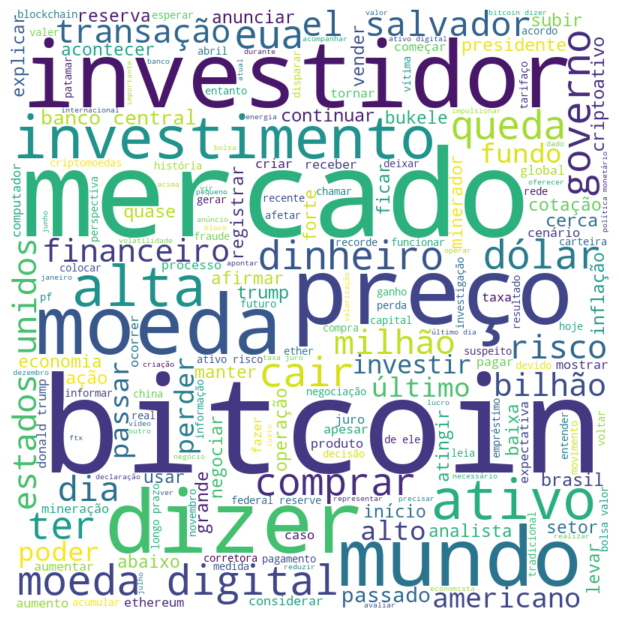

In [4]:
stopwords = list(nltk.corpus.stopwords.words('portuguese')) + [
    'bitcoin', 
    'criptomoeda', 
    'país', 
    'empresa', 
    'ano', 
    'pessoa', 
    'bitcoim',
    'chegar',
    'plataforma',
    'cripto',
    'seguir',
    'semana',
    'principal'
    ]

stemmer = SnowballStemmer('portuguese')

def clean_text_with_spacy(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    tokens = [token.lower() for token in tokens if token not in stopwords]
    return ' '.join(tokens)

cleaned_titles_with_spacy = [clean_text_with_spacy(text) for text in tqdm(texts)]

titles_combined = ' '.join(cleaned_titles_with_spacy)
wordcloud = WordCloud(width=800,
                      height=800,
                      background_color='white',
                      min_font_size=10).generate(titles_combined)

plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()